In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')  # Ensure NLTK's punkt package is downloaded for sentence tokenization
import json
import re
from IPython.display import Image

[nltk_data] Downloading package punkt to
[nltk_data]     /home/pratimathapa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

In [35]:
import bertopic

print(bertopic.__version__)

0.15.0


In [36]:
# Provide the path to your Excel file
file_path = '/home/pratimathapa/code/PratimaThapa/DisLex_Project/csv_files/English/combined_table_eng.xlsx'  # Replace with your file path

# Read the Excel file
data = pd.read_excel(file_path)

# Display the contents of the Excel file
data.head()


Sentence Language  Country
0  REPUBLIC OF VANUATU  Assent:  Commencement:  2...  English  Vanuatu
1  Be it enacted by lbe President and Parliament ...  English  Vanuatu
2  Geological Hazards and Climate Change;  disast...  English  Vanuatu
3  23 oj2()19  4  PART 1  PRELIMINARY MATTERS  <a...  English  Vanuatu
4  2501'2016;  National Cluster means a Govemment...  English  Vanuatu

In [37]:
data.shape

(11719, 3)

# Cleaning the data

In [38]:
# Convert column to strings
data['Sentence'] = data['Sentence'].astype(str)

# Filter rows where 'Sentence' column doesn't contain any numbers
data = data[~data['Sentence'].str.contains(r'\d', regex=True)]

# Making the rows continuous after getting rid of some of them
data = data.reset_index(drop=True)

# Display the updated DataFrame
print(data.head())  # Adjust as needed

                                            Sentence Language  Country
0  Geological Hazards and Climate Change;  disast...  English  Vanuatu
1                   Disaster Risk Management Act No.  English  Vanuatu
2                   Disaster Risk Management Act No.  English  Vanuatu
3  unclions ofthe Committee  The Committee has lh...  English  Vanuatu
4  (R)  Subject to this Act, the Committee may de...  English  Vanuatu


In [39]:
# Creating a list of dictionary of the keywords

name = ['disaster_origin', 'actors', 'disaster_cycle', 'governance_modalities', 'overarching_principles']

words = [
    ['natural', 'earthquake', 'floods', 'weather', 'drought', 'landslides', 'cyclones', 'tsunami', 'climate', 'volcanoes', 'technological disaster',
     'pollution', 'pandemic', 'epidemic', 'disease', 'conflict', 'war', 'civil conflict', 'multi hazards', 'cross sectoral'],
    ['national', 'national authorities', 'president', 'prime minister', 'centralized', 'federal', 'regional government', 'local government',
     'provincial government', 'decentralized', 'chief ministers', 'cabinet ministers', 'district', 'director general', 'parliament', 'parliamentary',
     'members of parliament', 'executive', 'legal actors', 'supreme court', 'high court', 'tribunal', 'administrative', 'administration',
     'bureaucratic capacity', 'private actors', 'companies', 'multinational', 'United Nations', 'European Union', 'international', 'African Union',
     'International development agencies', 'financial institutions', 'military', 'army', 'soldiers', 'military asset'],
    ['disaster risk reduction', 'disaster risk', 'DRR', 'mitigation', 'disaster preparedness', 'preparedness', 'planning', 'response',
     'disaster response', 'emergency', 'relief', 'early warning', 'recovery', 'reconstruction', 'rehabilitation', 'capacity development'],
    ['state of emergency declaration', 'state of exception', 'state of alarm', 'courts', 'judges', 'legal review', 'participatory', 'participation',
     'decision', 'decision making', 'responsibility', 'implementation', 'implementing', 'accountability', 'liability', 'reporting', 'coordination',
     'cooperation', 'network', 'collaboration', 'partnership', 'multiorganizational', 'disaster management agency', 'disaster management platform',
     'personnel', 'migrants', 'gender', 'minority', 'women', 'young people', 'elderly', 'old people', 'disabled people', 'vulnerable communities',
     'vulnerable people', 'children', 'financially unstable', 'no housing', 'lgbtqi+', 'fund', 'funding', 'financing', 'resource management'],
    ['humanitarian principles', 'neutrality', 'independence', 'impartiality', 'humanity', 'Sustainable development goals', 'Sendai Framework',
     'international humanitarian law', 'IHL', 'Geneva Convention', 'International Community of the Red Cross', 'international guidelines',
     'international frameworks', 'human rights', 'right-based approach', 'democratic resilience', 'democratic continuity', 'democratic decision making',
     'quality standards', 'anti corruption', 'corruption', 'financial transparency', 'sovereignty', 'sovereign', 'access to information', 'compensation',
     'compensatory measures', 'legal protection', 'civil protection']
]

# Create a list of dictionaries using a list comprehension
result_list = [
    {"name": n, "words": w} for n, w in zip(name, words)
]

# Display the resulting list of dictionaries
for item in result_list:
    print(item)


{'name': 'disaster_origin', 'words': ['natural', 'earthquake', 'floods', 'weather', 'drought', 'landslides', 'cyclones', 'tsunami', 'climate', 'volcanoes', 'technological disaster', 'pollution', 'pandemic', 'epidemic', 'disease', 'conflict', 'war', 'civil conflict', 'multi hazards', 'cross sectoral']}
{'name': 'actors', 'words': ['national', 'national authorities', 'president', 'prime minister', 'centralized', 'federal', 'regional government', 'local government', 'provincial government', 'decentralized', 'chief ministers', 'cabinet ministers', 'district', 'director general', 'parliament', 'parliamentary', 'members of parliament', 'executive', 'legal actors', 'supreme court', 'high court', 'tribunal', 'administrative', 'administration', 'bureaucratic capacity', 'private actors', 'companies', 'multinational', 'United Nations', 'European Union', 'international', 'African Union', 'International development agencies', 'financial institutions', 'military', 'army', 'soldiers', 'military asset

In [40]:
# Define a function to create seed list from a dictionary
def get_seed_lists(dictionary, ngram_size):
    # create list of topics wit max ngram_size
    seeds = []
    for topic in dictionary:
        seed = [w for w in topic["words"] if len(w.split()) <= ngram_size]
        seeds.append(seed)
    return seeds


In [41]:
# Create seed list from dictionary
seeds = get_seed_lists(result_list, 1)
print(seeds)


[['natural', 'earthquake', 'floods', 'weather', 'drought', 'landslides', 'cyclones', 'tsunami', 'climate', 'volcanoes', 'pollution', 'pandemic', 'epidemic', 'disease', 'conflict', 'war'], ['national', 'president', 'centralized', 'federal', 'decentralized', 'district', 'parliament', 'parliamentary', 'executive', 'tribunal', 'administrative', 'administration', 'companies', 'multinational', 'international', 'military', 'army', 'soldiers'], ['DRR', 'mitigation', 'preparedness', 'planning', 'response', 'emergency', 'relief', 'recovery', 'reconstruction', 'rehabilitation'], ['courts', 'judges', 'participatory', 'participation', 'decision', 'responsibility', 'implementation', 'implementing', 'accountability', 'liability', 'reporting', 'coordination', 'cooperation', 'network', 'collaboration', 'partnership', 'multiorganizational', 'personnel', 'migrants', 'gender', 'minority', 'women', 'elderly', 'children', 'lgbtqi+', 'fund', 'funding', 'financing'], ['neutrality', 'independence', 'impartiali

In [42]:
#Using Legal bert for sentence embedding
# Prepare embeddings
from sentence_transformers import SentenceTransformer
docs = data.Sentence
sentence_model = SentenceTransformer("nlpaueb/legal-bert-base-uncased")

# Use KeyBERTInspired representation model.
# This gives better names to the topics.
representation_model = KeyBERTInspired()
embeddings = sentence_model.encode(docs, show_progress_bar=True)

No sentence-transformers model found with name /home/pratimathapa/.cache/torch/sentence_transformers/nlpaueb_legal-bert-base-uncased. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [43]:
display(docs.shape)
embeddings.shape


(2984,)

(2984, 768)

In [44]:
seed_topic_list = get_seed_lists(result_list, 1)
topic_model = BERTopic(representation_model=representation_model,
                       seed_topic_list=seed_topic_list,
                       verbose=True,
                       embedding_model='nlpaueb/legal-bert-base-uncased',
                       min_topic_size = 7,
                       n_gram_range=(1, 2)
                      ).fit(docs, embeddings)

No sentence-transformers model found with name /home/pratimathapa/.cache/torch/sentence_transformers/nlpaueb_legal-bert-base-uncased. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-12 12:21:34,621 - BERTopic - Reduced dimensionality
2023-12-12 12:21:34,702 - BERTopic - Clustered reduced embeddings


In [45]:
topic_model.visualize_documents(docs, embeddings=embeddings)

In [46]:
# visualize topic words/n_grams
fig = topic_model.visualize_barchart(top_n_topics=20)
fig.show()

# Save the figure as a png file
fig.write_image('/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot1.png', format='png')

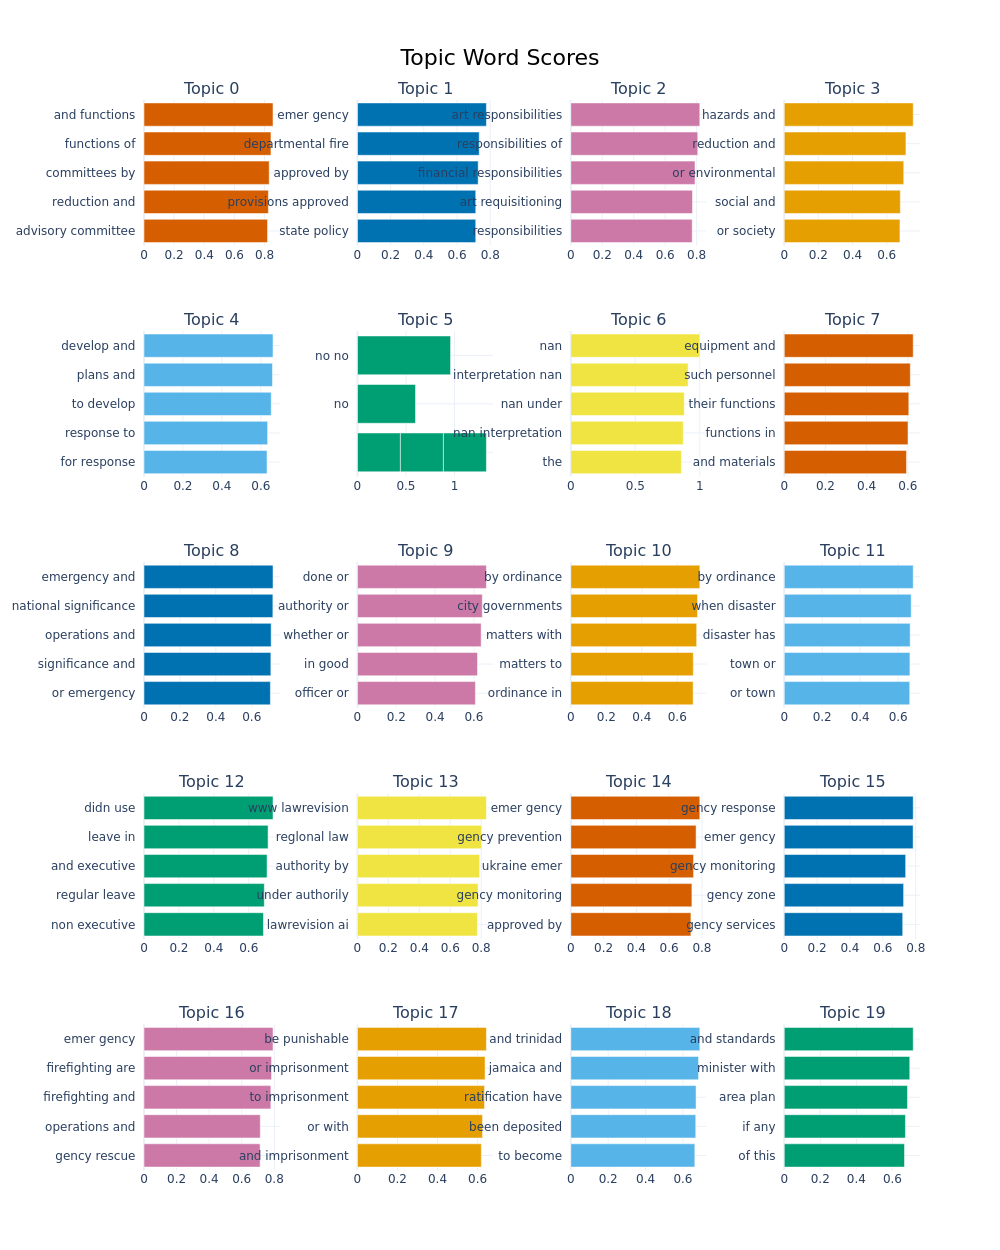

In [47]:
# Display the image
Image(filename='/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot1.png', width=800)

<img src="/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot1.png" width="800" />

# Getting rid of frequent words

In [48]:
# Prepare embeddings
from sentence_transformers import SentenceTransformer
docs = data.Sentence
sentence_model = SentenceTransformer("nlpaueb/legal-bert-base-uncased")

# Use KeyBERTInspired representation model.
# This gives better names to the topics.
representation_model = KeyBERTInspired()
embeddings = sentence_model.encode(docs, show_progress_bar=True)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

No sentence-transformers model found with name /home/pratimathapa/.cache/torch/sentence_transformers/nlpaueb_legal-bert-base-uncased. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [49]:
seed_topic_list = get_seed_lists(result_list, 1)
topic_model = BERTopic(representation_model=representation_model,
                       seed_topic_list=seed_topic_list,
                       verbose=True,
                       embedding_model='nlpaueb/legal-bert-base-uncased',
                       ctfidf_model=ctfidf_model,
                       min_topic_size = 10,
                       n_gram_range=(1, 1)
                      ).fit(docs, embeddings)

No sentence-transformers model found with name /home/pratimathapa/.cache/torch/sentence_transformers/nlpaueb_legal-bert-base-uncased. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-12 12:26:07,591 - BERTopic - Reduced dimensionality
2023-12-12 12:26:07,700 - BERTopic - Clustered reduced embeddings


In [50]:
topic_model.visualize_documents(docs, embeddings=embeddings)

In [51]:
# visualize topic words/n_grams
fig = topic_model.visualize_barchart(top_n_topics=20)
fig.show()

# Save the figure as a png file
fig.write_image('/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot2.png', format='png')

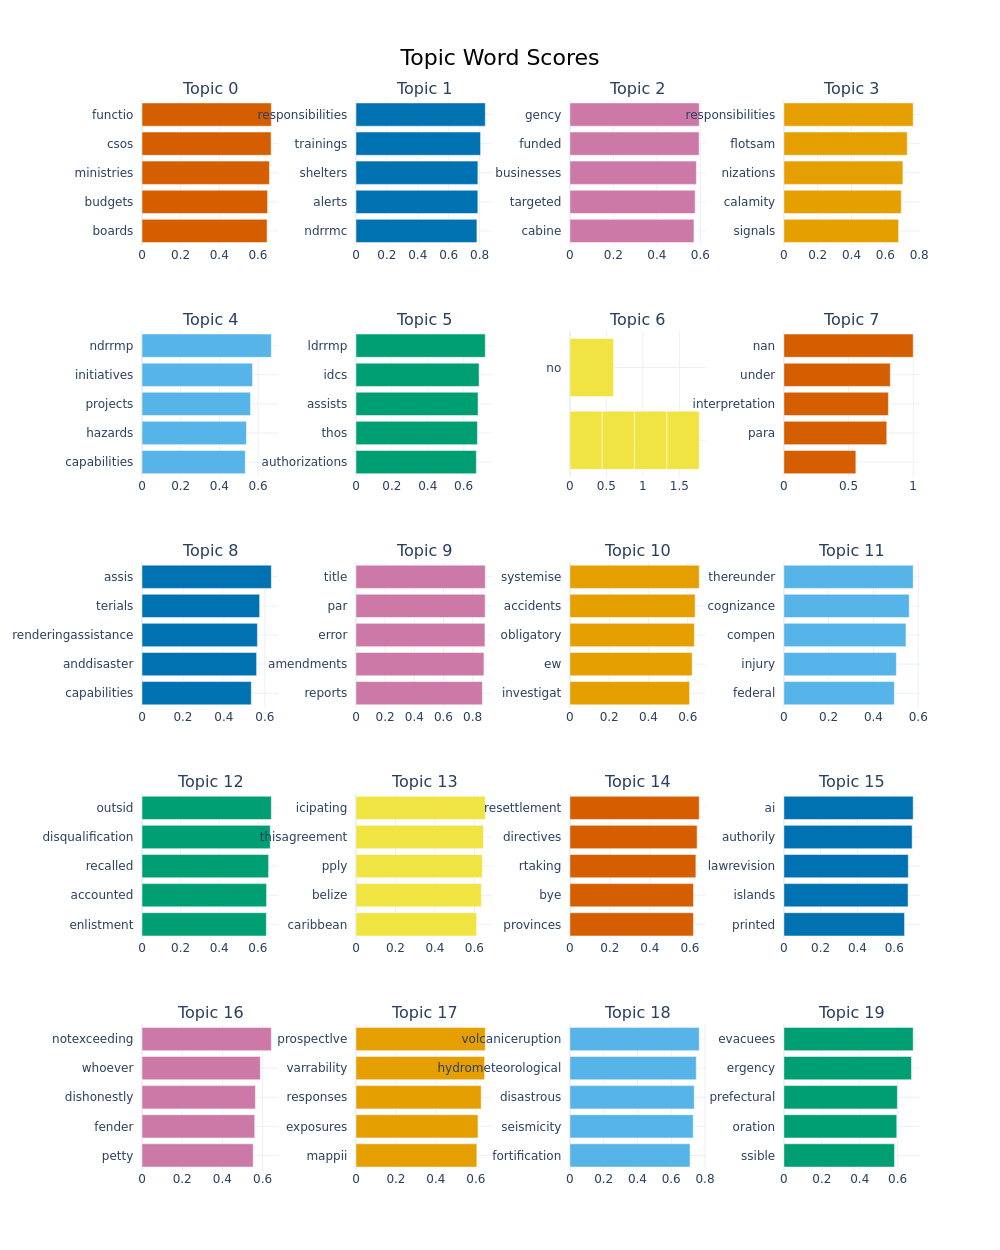

In [52]:
# Display the image
Image(filename='/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot2.png', width=800)

<img src="/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot2.png" width="800" />

# Limiting the number of duplicate words in each topic

In [53]:
# Prepare embeddings
from sentence_transformers import SentenceTransformer
docs = data.Sentence
sentence_model = SentenceTransformer("nlpaueb/legal-bert-base-uncased")

# Use KeyBERTInspired representation model.
# This gives better names to the topics.
#representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.5)
embeddings = sentence_model.encode(docs, show_progress_bar=True)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

No sentence-transformers model found with name /home/pratimathapa/.cache/torch/sentence_transformers/nlpaueb_legal-bert-base-uncased. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [54]:
seed_topic_list = get_seed_lists(result_list, 1)
topic_model = BERTopic(representation_model=representation_model,
                       seed_topic_list=seed_topic_list,
                       verbose=True,
                       embedding_model='nlpaueb/legal-bert-base-uncased',
                       ctfidf_model=ctfidf_model,
                       min_topic_size = 10,
                       n_gram_range=(1, 1)
                      ).fit(docs, embeddings)

No sentence-transformers model found with name /home/pratimathapa/.cache/torch/sentence_transformers/nlpaueb_legal-bert-base-uncased. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-12 12:30:22,568 - BERTopic - Reduced dimensionality
2023-12-12 12:30:22,662 - BERTopic - Clustered reduced embeddings


In [55]:
topic_model.visualize_documents(docs, embeddings=embeddings)

In [56]:
import plotly.graph_objects as go
# visualize topic words/n_grams
fig = topic_model.visualize_barchart(top_n_topics=54)
#fig.show()
# Save the figure as a png file
fig.write_image('/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot3.png', format='png')

<img src="/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot3.png" />

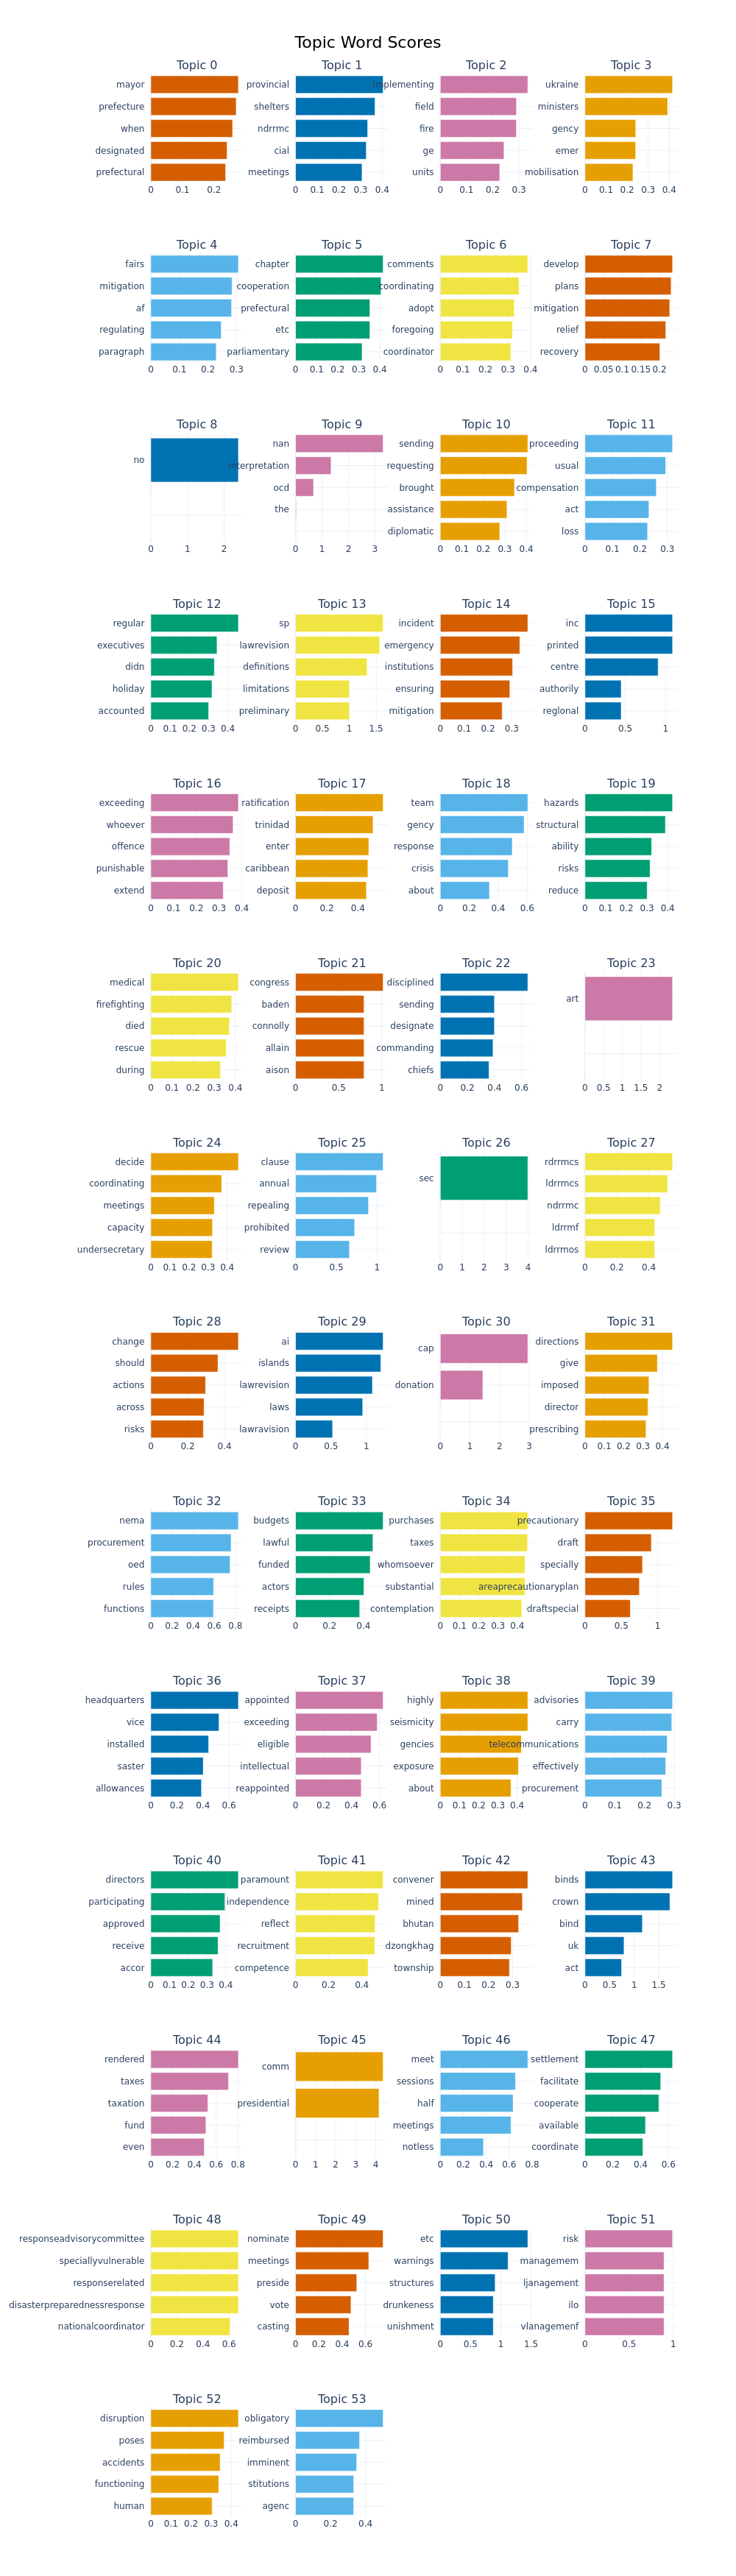

In [57]:
from IPython.display import Image

# Display the image
Image(filename='/home/pratimathapa/code/PratimaThapa/DisLex_Project/notebooks/images/plot3.png', width=800)